In [40]:
import torch
import torch.nn as nn
from merlin import QuantumLayer, ComputationSpace, LexGrouping
from merlin.builder import CircuitBuilder

In [41]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:

    X = df.iloc[:, 1:-1].values
    y = df.iloc[:, -1].values
    print('X = ', X)

    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X)
    print("X train = ", X_train)
            
    print("Preprocessing complete.")

    return X_train,y

In [42]:
import numpy as np
import perceval as pcvl
import torch
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from merlin.algorithms.kernels import FeatureMap, FidelityKernel, KernelCircuitBuilder

X_train=pd.read_csv('C:\\Users\\GhadaBenSlama\\bqh-qatar-2025-qib\\.aqora\\data\\data\\credit_train.csv')
X_train,y_train = preprocess_data(X_train)

X_test=pd.read_csv('C:\\Users\\GhadaBenSlama\\bqh-qatar-2025-qib\\.aqora\\data\\data\\credit_test.csv')
X_test,y_test = preprocess_data(X_test)


X_train = torch.tensor(X_train,dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

X =  [[ 0.619  0.529  0.418 14.     0.308  0.516]
 [ 0.473  0.434  0.829 17.     0.352  0.945]
 [ 0.389  0.724  0.848  7.     0.604  0.629]
 ...
 [ 0.328  0.94   0.693  2.     0.809  0.826]
 [ 0.452  0.424  0.753 14.     0.383  0.646]
 [ 0.416  0.526  0.503 15.     0.489  0.606]]
X train =  [[0.61158798 0.55075594 0.37852495 0.8125     0.308      0.31054131]
 [0.45493562 0.44816415 0.82429501 1.         0.352      0.92165242]
 [0.36480687 0.76133909 0.84490239 0.375      0.604      0.47150997]
 ...
 [0.29935622 0.99460043 0.67678959 0.0625     0.809      0.75213675]
 [0.43240343 0.43736501 0.74186551 0.8125     0.383      0.4957265 ]
 [0.39377682 0.5475162  0.47071584 0.875      0.489      0.43874644]]
Preprocessing complete.
X =  [[ 0.629  0.465  0.489 10.     0.419  0.764]
 [ 0.676  0.178  0.616  9.     0.181  0.641]
 [ 0.678  0.466  0.8   13.     0.338  0.569]
 ...
 [ 0.37   0.377  0.725  4.     0.397  0.942]
 [ 0.771  0.4    0.496 10.     0.111  0.497]
 [ 0.947  0.677  0.905  9.   

In [43]:
from collections import defaultdict

import matplotlib.pyplot as plt
import perceval as pcvl
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

%matplotlib inline

from merlin import LexGrouping, ModGrouping, QuantumLayer

In [44]:
from dataclasses import dataclass
from typing import Literal

import torch


@dataclass
class MLPConfig:
    """Configuration for Multi-Layer Perceptron"""
    hidden_sizes: list[int] = None
    dropout: float = 0.0
    activation: Literal["relu", "tanh", "sigmoid", "leaky_relu", "elu", "gelu", "selu"] = "relu"
    normalization: Literal["batch", "layer"] | None = None


class MLP(nn.Module):
    """
    An enhanced Multi-Layer Perceptron (MLP) implementation with customizable options.

    Features:
    - Multiple activation functions
    - Batch/Layer normalization options
    - Customizable weight initialization

    Args:
        input_size (int): Dimension of the input features
        output_size (int): Dimension of the output
        config (MLPConfig): Configuration for the network architecture
    """

    # Class-level mapping of available activation functions
    ACTIVATIONS = {
        "relu": nn.ReLU(),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "leaky_relu": nn.LeakyReLU(),
        "elu": nn.ELU(),
        "gelu": nn.GELU(),
        "selu": nn.SELU(),
    }

    def __init__(self, input_size: int, output_size: int, config: MLPConfig):
        super().__init__()
        last_layer_size = input_size
        layers = []

        self.config = config

        # Validate activation function
        if config.activation not in self.ACTIVATIONS:
            raise ValueError(f"Unsupported activation function: {config.activation}")

        # Build network architecture
        for layer_size in config.hidden_sizes:
            # Add linear layer
            layers.append(nn.Linear(last_layer_size, layer_size))

            # Add normalization if specified
            if config.normalization == "batch":
                layers.append(nn.BatchNorm1d(layer_size))
            elif config.normalization == "layer":
                layers.append(nn.LayerNorm(layer_size))

            # Add activation function
            layers.append(self.ACTIVATIONS[config.activation])

            # Add dropout if specified
            if config.dropout > 0:
                layers.append(nn.Dropout(config.dropout))

            last_layer_size = layer_size

        # Add final output layer
        layers.append(nn.Linear(last_layer_size, output_size))

        # Create sequential model from layers
        self.network = nn.Sequential(*layers)

    def initialize_weights(self, method="xavier"):
        """
        Initialize network weights using the specified method.

        Args:
            method (str): Initialization method ('xavier' or 'kaiming') (default: 'xavier')
        """

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                if method == "xavier":
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
                elif method == "kaiming":
                    nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
                    nn.init.zeros_(layer.bias)
                else:
                    raise ValueError(f"Unsupported initialization method: {method}")

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, input_size)

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, output_size)
        """
        return self.network(x)


In [57]:
def get_model_variants():
    """Define different variants for each model type"""
    # Define consistent colors for each model type
    MODEL_COLORS = {
        "MLP": "#1f77b4",  # Blue
        "LINEAR": "#2ca02c",  # Green
        "GROUPING": "#ff7f0e",  # Orange
    }

    # Define line styles for variants
    LINE_STYLES = ["--", "-", ":", "-."]

    variants = {
        "MLP": [
            {
                "name": "MLP",
                "config": MLPConfig(hidden_sizes=[8], dropout=0.1, activation="relu"),
                "color": MODEL_COLORS["MLP"],
                "linestyle": LINE_STYLES[0],
            }
        ],
        "LINEAR": [
            {
                "name": "LINEAR-7modes-nobunching",
                "config": {
                    "m": 7,
                    "post_processing": "linear",
                    "no_bunching": True,
                },
                "color": MODEL_COLORS["LINEAR"],
                "linestyle": LINE_STYLES[1],
            }
        ],
        # "GROUPING": [
        #     {
        #         "name": "LEXGROUPING-7modes",
        #         "config": {
        #             "m": 8,
        #             "post_processing": "lex",
        #         },
        #         "color": MODEL_COLORS["GROUPING"],
        #         "linestyle": LINE_STYLES[2],
        #     },
        #     {
        #         "name": "MODGROUPING-7modes",
        #         "config": {
        #             "m": 8,
        #             "post_processing": "mod",
        #         },
        #         "color": MODEL_COLORS["GROUPING"],
        #         "linestyle": LINE_STYLES[1],
        #     },
        # ],
    }
    return variants

In [58]:
from perceval.components import catalog
q1, q2, q3 = [0,1], [2,3], [4,5]
def featuremap(m):
    circuit_rx = pcvl.Circuit(2) // (0, PS(np.pi)) // BS.Rx(theta=pcvl.P("theta")) // (0, PS(np.pi))
    Rz = lambda i: pcvl.Circuit(2,name=f"Rz{i}") // BS.H() // circuit_rx // BS.H()
    cz = catalog['heralded cz'].build_circuit()
    circuit = pcvl.Circuit(m)
    # circuit = pcvl.Processor("SLOS",6)  
    circuit.add(0, BS())
    circuit.add(2, BS())
    circuit.add(4, BS())
    circuit.add(0, Rz(pcvl.P(f"px{1}")))
    circuit.add(1, Rz(pcvl.P(f"px{2}")))
    circuit.add(2, Rz(pcvl.P(f"px{3}")))
    circuit.add(3, Rz(pcvl.P(f"px{4}")))
    circuit.add(4, Rz(pcvl.P(f"px{5}")))
    circuit.add(5, Rz(pcvl.P(f"px{6}")))
    circuit.add(0, cz)
    circuit.add(2,cz)

    return circuit

    

In [59]:
import perceval as pcvl
import numpy as np
from perceval.components import PS, BS, PERM
def create_quantum_circuit(m):
    """Create quantum circuit with specified number of modes

    Parameters:
    -----------
    m : int
        Number of quantum modes in the circuit

    Returns:
    --------
    pcvl.Circuit
        Complete quantum circuit with trainable parameters
    """
    m+=1
    # Left interferometer with trainable parameters
    wl = pcvl.GenericInterferometer(
        m,
        lambda i: pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_li{i}"))
        // pcvl.BS(),
        #// pcvl.PS(pcvl.P(f"theta_lo{i}")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    # Variable phase shifters for input encoding
    c_var = pcvl.Circuit(m)
    for i in range(6):  # 6 input features
        px = pcvl.P(f"px{i + 1}")
        c_var.add(i + (m - 4) // 2, pcvl.PS(px))

    # Right interferometer with trainable parameters
    wr = pcvl.GenericInterferometer(
        m,
        lambda i: pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_ri{i}"))
        // pcvl.BS(),
        #// pcvl.PS(pcvl.P(f"theta_ro{i}")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    # Combine all components
    c = pcvl.Circuit(m)
    # c = pcvl.Processor("SLOS",7)
    c.add(0,featuremap(m))
    c.add(0, wl)
    c.add(0, c_var)
    c.add(0, wr)
    c.add(0, c_var)

    return c

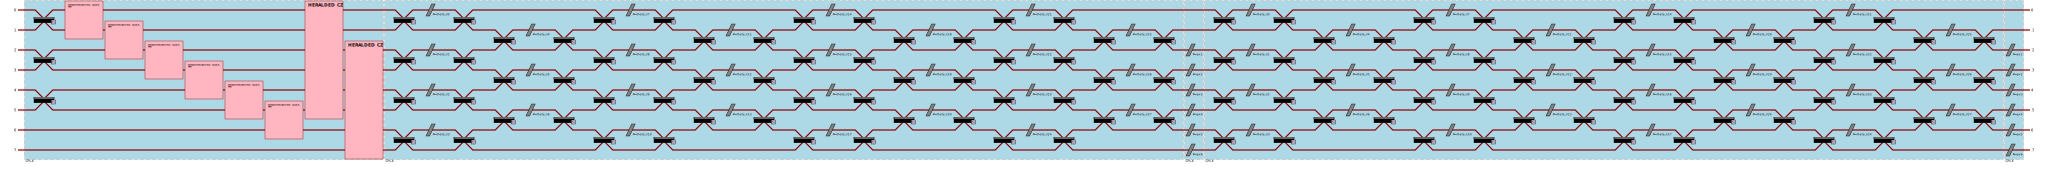

In [60]:
circuit=create_quantum_circuit(7)
pcvl.pdisplay(circuit, recursive=True)

In [61]:
# import perceval as pcvl
# import numpy as np
# from perceval.component
# 
# s import PS, BS, PERM
# def create_quantum_circuit(m):
#     """Create quantum circuit with specified number of modes

#     Parameters:
#     -----------
#     m : int
#         Number of quantum modes in the circuit

#     Returns:
#     --------
#     pcvl.Circuit
#         Complete quantum circuit with trainable parameters
#     """

#     c_var = pcvl.Circuit(m)
#     m+=1
#     for i in range(6):  # 6 input features
#         px = pcvl.P(f"px{i + 1}")
#         c_var.add(i, pcvl.PS(px))

#     c = pcvl.Circuit(m)
#     c.add(0, PS(pcvl.P(f"px{1}")))
#     c.add(1, PS(pcvl.P(f"px{2}")))


#     circuit = pcvl.Circuit(m)  
#     circuit.add(0, BS())
#     circuit.add(2, BS())
#     circuit.add(4, BS())
#     circuit.add(0, c_var, merge=True)
#     # circuit.add(0, PS(pcvl.P(f"px{1}")))
#     # circuit.add(1, PS(pcvl.P(f"px{2}")))
#     # circuit.add(2, PS(pcvl.P(f"px{3}")))
#     # circuit.add(3, PS(pcvl.P(f"px{4}")))
#     # circuit.add(4, PS(pcvl.P(f"px{5}")))
#     # circuit.add(5, PS(pcvl.P(f"px{6}")))



#     circuit.add(0, BS())  # The beam splitter is added to the circuit on mode 0 and 1
#     circuit.add(0, PS(pcvl.P(f"theta{1}")))
#     circuit.add(1, PS(pcvl.P(f"theta{2}")))
#     circuit.add(1, BS())
#     circuit.add(1, PS(pcvl.P(f"theta{3}")))
#     circuit.add(2, PS(pcvl.P(f"theta{4}")))
#     circuit.add(0, BS())
#     circuit.add(2, BS())
#     circuit.add(2, PS(pcvl.P(f"theta{5}")))
#     circuit.add(3, PS(pcvl.P(f"theta{8}")))
#     circuit.add(2, BS())
#     circuit.add(3, BS())
#     circuit.add(3, PS(pcvl.P(f"theta{6}")))
#     circuit.add(4, PS(pcvl.P(f"theta{9}")))
#     circuit.add(3, BS())
#     circuit.add(4, BS())
#     circuit.add(4, PS(pcvl.P(f"theta{7}")))
#     circuit.add(5, PS(pcvl.P(f"theta{10}")))
#     circuit.add(4, BS())

#     circuit.add(0, BS())
#     circuit.add(2, BS())
#     # circuit.add(4, BS())
#     # circuit.add(0, PS(pcvl.P(f"px{13}")))
#     # circuit.add(1, PS(pcvl.P(f"px{14}")))
#     # circuit.add(2, PS(pcvl.P(f"px{15}")))
#     # circuit.add(3, PS(pcvl.P(f"px{16}")))
#     # circuit.add(5, PS(pcvl.P(f"px{17}")))
#     circuit.add(0, c_var, merge=True)

#     # circuit.add(2, PS(pcvl.P(f"px{3}")).add(3, PS(pcvl.P(f"px{4}")))).add(1, BS())
#     # circuit.add(4, PS(pcvl.P(f"px{5}"))).add(5, PS((pcvl.P(f"px{6}")))).add(1, BS())
#     return(circuit)

In [62]:
def create_model(model_type, variant):
    """Create model instance based on type and variant

    Parameters:
    -----------
    model_type : str
        Type of model ('MLP' or quantum model types)
    variant : dict
        Configuration dictionary for the model variant

    Returns:
    --------
    nn.Module
        PyTorch model instance
    """
    if model_type == "MLP":
        return MLP(input_size=6, output_size=3, config=variant["config"])
    else:
        m = variant["config"]["m"]
        no_bunching = variant["config"].get("no_bunching", False)
        post_processing = variant["config"].get("post_processing")
        c = create_quantum_circuit(m)
        quantum_layer = QuantumLayer(
            input_size=6,
            circuit=c,
            trainable_parameters=["theta"],
            input_parameters=["px"],
            input_state=[1, 0] * (m // 2) + [0] * (m % 2),
            no_bunching=no_bunching,
        )

        if post_processing == "linear":
            head = nn.Linear(quantum_layer.output_size, 2)
            return nn.Sequential(quantum_layer, head)
        # if post_processing == "lex":
        #     return nn.Sequential(
        #         quantum_layer,
        #         LexGrouping(quantum_layer.output_size, 2),
        #     )
        # if post_processing == "mod":
        #     return nn.Sequential(
        #         quantum_layer,
        #         ModGrouping(quantum_layer.output_size, 2),
        #     )
        return quantum_layer


def count_parameters(model):
    """Count trainable parameters in a PyTorch model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [63]:
def train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    n_epochs=50,
    batch_size=32,
    lr=0.02,
):
    """Train a model and track metrics

    Parameters:
    -----------
    model : nn.Module
        Model to train
    X_train, y_train : torch.Tensor
        Training data and labels
    X_test, y_test : torch.Tensor
        Test data and labels
    model_name : str
        Name for progress bar display
    n_epochs : int
        Number of training epochs
    batch_size : int
        Batch size for mini-batch training
    lr : float
        Learning rate

    Returns:
    --------
    dict
        Training results including losses, accuracies, and final report
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()

    pbar = tqdm(range(n_epochs), leave=False, desc=f"Training {model_name}")
    for _epoch in pbar:
        # Shuffle training data
        permutation = torch.randperm(X_train.size()[0])
        total_loss = 0

        # Mini-batch training
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (X_train.size()[0] // batch_size)
        losses.append(avg_loss)
        pbar.set_description(f"Training {model_name} - Loss: {avg_loss:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Training accuracy
            train_outputs = model(X_train)
            train_preds = torch.argmax(train_outputs, dim=1).numpy()
            train_acc = accuracy_score(y_train.numpy(), train_preds)
            train_accuracies.append(train_acc)

            # Test accuracy
            test_outputs = model(X_test)
            test_preds = torch.argmax(test_outputs, dim=1).numpy()
            test_acc = accuracy_score(y_test.numpy(), test_preds)
            test_accuracies.append(test_acc)

        model.train()

    # Generate final classification report
    model.eval()
    with torch.no_grad():
        final_test_outputs = model(X_test)
        final_test_preds = torch.argmax(final_test_outputs, dim=1).numpy()
        final_report = classification_report(y_test.numpy(), final_test_preds)

    return {
        "losses": losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "final_test_acc": test_accuracies[-1],
        "classification_report": final_report,}

In [64]:
def train_all_variants(X_train, y_train, X_test, y_test, num_runs=5):
    """Train all model variants multiple times and return results

    Parameters:
    -----------
    X_train, y_train : torch.Tensor
        Training data and labels
    X_test, y_test : torch.Tensor
        Test data and labels
    num_runs : int
        Number of independent training runs per variant

    Returns:
    --------
    tuple
        (all_results, best_models) - Complete results and best performing models
    """
    variants = get_model_variants()
    all_results = defaultdict(dict)
    best_models = {}

    for model_type, model_variants in variants.items():
        print(f"\n\nTraining {model_type} variants:")
        best_acc = 0

        for variant in model_variants:
            print(
                f"\nTraining {variant['name']}... ({count_parameters(create_model(model_type, variant))} parameters)"
            )

            # Store results from multiple runs
            variant_runs = []

            for run in range(num_runs):
                model = create_model(model_type, variant)
                print(f"  Run {run + 1}/{num_runs}...")

                results = train_model(
                    model,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    f"{variant['name']}-run{run + 1}",
                )
                results["model"] = model
                results["color"] = variant["color"]
                results["linestyle"] = variant["linestyle"]
                variant_runs.append(results)

                # Track best model for each type
                if results["final_test_acc"] > best_acc:
                    best_acc = results["final_test_acc"]
                    best_models[model_type] = {
                        "name": variant["name"],
                        "model": model,
                        "results": results,
                    }

            # Store all runs for this variant
            all_results[model_type][variant["name"]] = {
                "runs": variant_runs,
                "color": variant["color"],
                "linestyle": variant["linestyle"],
                "avg_final_test_acc": sum(run["final_test_acc"] for run in variant_runs)
                / num_runs,
            }

    return all_results, best_models

In [65]:
def plot_training_curves(all_results):
    """Plot training curves for all model variants with average and envelope

    Shows three subplots:
    1. Training loss over epochs
    2. Training accuracy over epochs
    3. Test accuracy over epochs

    Each line represents the mean across runs, with shaded areas showing min/max envelope.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Plot each metric
    for _model_type, variants in all_results.items():
        for variant_name, variant_data in variants.items():
            color = variant_data["color"]
            linestyle = variant_data["linestyle"]
            label = f"{variant_name}"

            # Get data from all runs
            losses_runs = [run["losses"] for run in variant_data["runs"]]
            train_acc_runs = [run["train_accuracies"] for run in variant_data["runs"]]
            test_acc_runs = [run["test_accuracies"] for run in variant_data["runs"]]

            # Calculate mean values across all runs
            epochs = len(losses_runs[0])
            mean_losses = [
                sum(run[i] for run in losses_runs) / len(losses_runs)
                for i in range(epochs)
            ]
            mean_train_acc = [
                sum(run[i] for run in train_acc_runs) / len(train_acc_runs)
                for i in range(epochs)
            ]
            mean_test_acc = [
                sum(run[i] for run in test_acc_runs) / len(test_acc_runs)
                for i in range(epochs)
            ]

            # Calculate min and max values for the envelope
            min_losses = [min(run[i] for run in losses_runs) for i in range(epochs)]
            max_losses = [max(run[i] for run in losses_runs) for i in range(epochs)]

            min_train_acc = [
                min(run[i] for run in train_acc_runs) for i in range(epochs)
            ]
            max_train_acc = [
                max(run[i] for run in train_acc_runs) for i in range(epochs)
            ]

            min_test_acc = [min(run[i] for run in test_acc_runs) for i in range(epochs)]
            max_test_acc = [max(run[i] for run in test_acc_runs) for i in range(epochs)]

            # Plot mean lines
            ax1.plot(
                mean_losses, label=label, color=color, linestyle=linestyle, linewidth=2
            )
            ax2.plot(
                mean_train_acc,
                label=label,
                color=color,
                linestyle=linestyle,
                linewidth=2,
            )
            ax3.plot(
                mean_test_acc,
                label=label,
                color=color,
                linestyle=linestyle,
                linewidth=2,
            )

            # Plot envelopes (filled area between min and max)
            epochs_range = range(epochs)
            ax1.fill_between(
                epochs_range, min_losses, max_losses, color=color, alpha=0.2
            )
            ax2.fill_between(
                epochs_range, min_train_acc, max_train_acc, color=color, alpha=0.2
            )
            ax3.fill_between(
                epochs_range, min_test_acc, max_test_acc, color=color, alpha=0.2
            )

    # Customize plots
    for ax, title in zip(
        [ax1, ax2, ax3],
        ["Training Loss", "Training Accuracy", "Test Accuracy"],
        strict=False,
    ):
        ax.set_title(title, fontsize=12, pad=10)
        ax.set_xlabel("Epoch", fontsize=10)
        ax.set_ylabel(title.split()[-1], fontsize=10)
        ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

In [66]:
def plot_best_confusion_matrices(best_models, X_test, y_test):
    """Plot confusion matrices for the best model of each type"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    class_names = ["setosa", "versicolor", "virginica"]

    for idx, (model_type, best) in enumerate(best_models.items()):
        model = best["model"]
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            predictions = torch.argmax(outputs, dim=1).numpy()

        cm = confusion_matrix(y_test.numpy(), predictions)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[idx],
        )
        axes[idx].set_title(f"Best {model_type}\n({best['name']})")
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("True")
        plt.setp(axes[idx].get_xticklabels(), rotation=45)
        plt.setp(axes[idx].get_yticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

In [67]:
def print_comparison_results(all_results, best_models):
    """Print detailed comparison of all models and variants with multi-run statistics"""
    print("\n----- Model Comparison Results -----")

    # Print results for all variants
    print("\nAll Model Variants Results (averaged over multiple runs):")
    for model_type, variants in all_results.items():
        print(f"\n{model_type} Variants:")
        for variant_name, variant_data in variants.items():
            print(f"\n{variant_name}:")
            print(f"Parameters: {count_parameters(variant_data['runs'][0]['model'])}")

            # Calculate statistics across runs
            final_accs = [run["final_test_acc"] for run in variant_data["runs"]]
            avg_acc = sum(final_accs) / len(final_accs)
            min_acc = min(final_accs)
            max_acc = max(final_accs)
            std_acc = (
                sum((acc - avg_acc) ** 2 for acc in final_accs) / len(final_accs)
            ) ** 0.5

            print(
                f"Final Test Accuracy: {avg_acc:.4f} ± {std_acc:.4f} (min: {min_acc:.4f}, max: {max_acc:.4f})"
            )

    # Print best model results
    print("\nBest Models:")
    for model_type, best in best_models.items():
        print(f"\nBest {model_type} Model: {best['name']}")
        print(f"Final Test Accuracy: {best['results']['final_test_acc']:.4f}")
        print(f"Classification Report:\n{best['results']['classification_report']}")

In [68]:
# Set number of independent runs per model variant
num_runs = 1

# Train all variants
print("Starting training process...")
all_results, best_models = train_all_variants(
    X_train, y_train, X_test, y_test, num_runs=num_runs
)

Starting training process...


Training MLP variants:

Training MLP... (83 parameters)
  Run 1/1...




Training LINEAR variants:

Training LINEAR-7modes-nobunching... (171 parameters)
  Run 1/1...


In [ ]:
X_train.shape

torch.Size([600, 6])

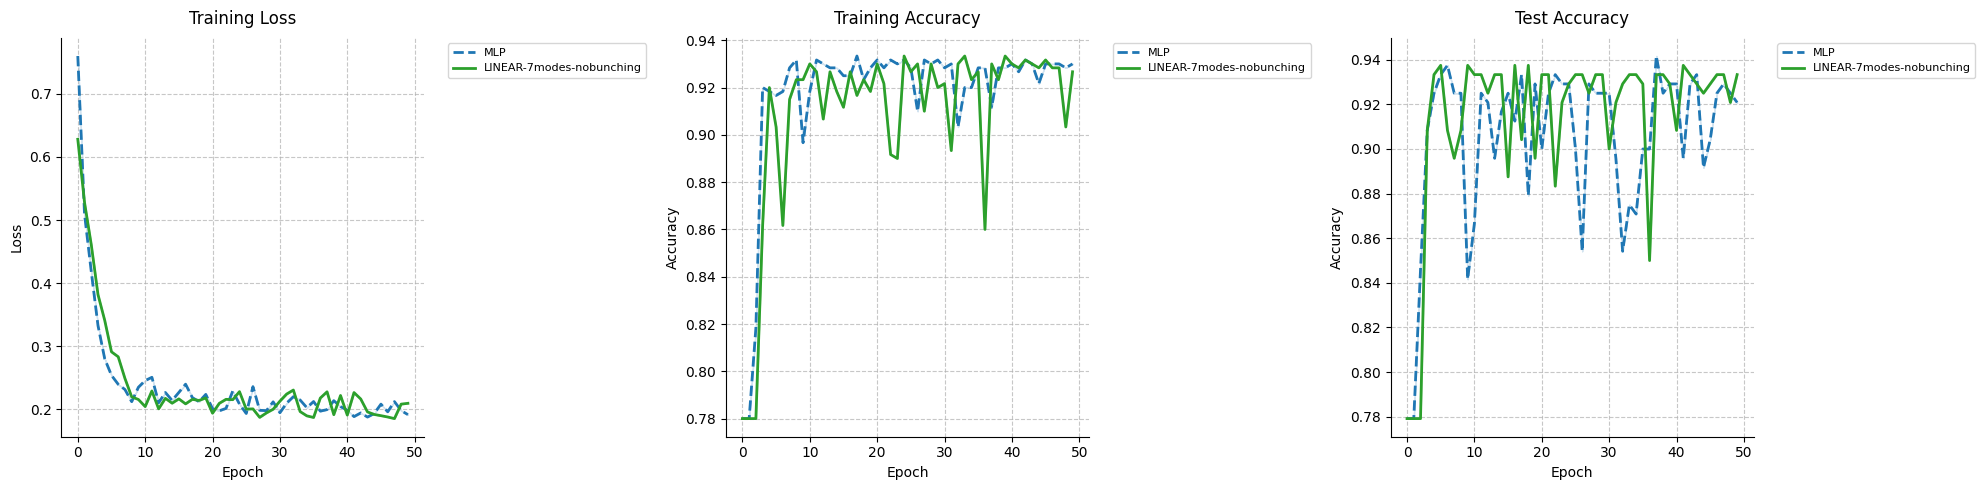


----- Model Comparison Results -----

All Model Variants Results (averaged over multiple runs):

MLP Variants:

MLP:
Parameters: 83
Final Test Accuracy: 0.9208 ± 0.0000 (min: 0.9208, max: 0.9208)

LINEAR Variants:

LINEAR-7modes-nobunching:
Parameters: 171
Final Test Accuracy: 0.9333 ± 0.0000 (min: 0.9333, max: 0.9333)

Best Models:

Best MLP Model: MLP
Final Test Accuracy: 0.9208
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       187
           1       0.77      0.92      0.84        53

    accuracy                           0.92       240
   macro avg       0.87      0.92      0.89       240
weighted avg       0.93      0.92      0.92       240


Best LINEAR Model: LINEAR-7modes-nobunching
Final Test Accuracy: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       187
           1       0.89      0.79      0.84        53

    a

In [69]:
plot_training_curves(all_results)
print_comparison_results(all_results, best_models)